In [1]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

import matplotlib
from skimage.transform import rotate, SimilarityTransform, warp, AffineTransform
from skimage.measure import regionprops

import statsmodels.api as sm
import statsmodels.formula.api as smf

import patato as pat
from palettable.cartocolors.qualitative import Pastel_3

from patato.useful_utilities import (
    add_axis_label,
    add_subfigure_label,
    linear_regression,
)

import scienceplots  # noqa

plt.style.use(["science", "nature", "no-latex"])

matplotlib.rcParams["font.sans-serif"] = ["Arial"]
matplotlib.rcParams["figure.constrained_layout.use"] = True

In [2]:
def rotate_image(im, theta, ax=None, scale=1, lines=None):
    x = im.get_array().copy()
    rows, cols = x.shape  # width, height
    # assert rows == cols

    theta = theta * np.pi / 180

    # Translate the image
    props = regionprops((~np.isnan(x)).astype(np.uint8))
    prop = max(props, key=lambda x: x.area)
    rowc, colc = prop.centroid

    # rotation around center
    blob_center = np.array((colc, rowc))
    center = np.array((cols, rows)) / 2 - 0.5

    tform1 = SimilarityTransform(translation=blob_center)
    tform2 = SimilarityTransform(rotation=theta)
    tform3 = SimilarityTransform(translation=-center)
    tform = tform3 + tform2 + tform1

    d = warp(x, tform, cval=np.nan)
    im.set_data(d)

    x0, x1, y0, y1 = im.get_extent()
    upper = False
    linetform = (
        AffineTransform(translation=(0.5, 0.5))
        + AffineTransform(
            scale=((x1 - x0) / (cols), (y1 - y0) / (rows) * (-1 if upper else 1))
        )
        + AffineTransform(translation=(x0, y0 * (-1 if upper else 1)))
    )

    if lines is not None:
        for y in lines:
            v = np.array(y.get_data())
            test = linetform(tform.inverse(linetform.inverse(v.T))).T
            y.set_data(test)

    # for scale, we'll just adjust the axis limits.
    if scale != 1:
        if ax is None:
            raise ValueError(
                "For rescaling, axes must be passed as a keyword argument."
            )
        else:
            a, b = ax.get_xlim()
            ax.set_xlim(a / scale, b / scale)
            a, b = ax.get_ylim()
            ax.set_ylim(a / scale, b / scale)
    return im

In [3]:
# Heavily pigmented image:

pa_pig = pat.PAData.from_hdf5("../data/mice/b6/Scan_40.hdf5")
roi_pig = pa_pig.get_rois()["body_", "0"]
pa_pig.set_default_recon()

# B6 non pigmented
pa_b6n = pat.PAData.from_hdf5("../data/mice/b6/Scan_2.hdf5")
roi_b6n = pa_b6n.get_rois()["body_", "0"]
pa_b6n.set_default_recon()

# Albino
pa_alb = pat.PAData.from_hdf5("../data/mice/albino/Scan_5.hdf5")
roi_alb = pa_alb.get_rois()["body_", "0"]
pa_alb.set_default_recon()

In [4]:
def fix_clims(ims, lower=None, upper=None):
    min_c = np.inf
    max_c = -np.inf
    for i in ims:
        a, b = i.get_clim()
        if min_c > a:
            min_c = a
        if max_c < b:
            max_c = b
    if lower is not None:
        min_c = lower
    if upper is not None:
        max_c = upper
    for i in ims:
        i.set_clim((min_c, max_c))

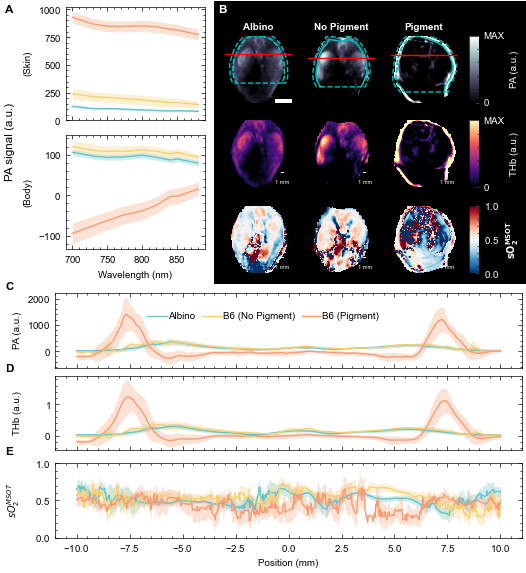

In [5]:
fig = plt.figure(figsize=(5.25, 8 * 5 / 7))

image_scale = 1.25

labels = ["Albino", "No Pigment", "Pigment"]
image_datasets = [pa_alb, pa_b6n, pa_pig]

rotation = []

subfigb, subfig_lineplots = fig.subfigures(2, height_ratios=(4, 4))

# Plot images
subfigc, subfigd = subfigb.subfigures(1, 2, width_ratios=(2, 3))

# --------------- Image grid ------------------------ #
subfigd.set_facecolor("black")

im_grid = subfigd.subplots(3, 3, sharex=True, sharey=True).flatten()

recs = []
thbs = []
so2s = []

df = pd.read_pickle("intermediate results/lineplots.pd").set_index("Scan name")

# Make the image grid.
for i in range(len(im_grid)):
    dataset = image_datasets[i % 3][0:1]
    wavelength = np.argmin(np.abs(dataset.get_wavelengths() - 800))
    dataset.set_default_recon()
    mask = dataset.get_rois()["body_", "0"]

    # Get the rim/core rois to add outline to figure:
    rois = dataset.get_rois(rim_core_distance=0.001, get_rim_cores=["body_"])
    roi_core = rois["body.core_", "0"]
    roi_rim = rois["body.rim_", "0"]
    mask_2 = dataset.get_rois()["body_", "1"]
    roi_core = roi_core.get_polygon() & mask_2.get_polygon()
    roi_rim = roi_rim.get_polygon() & mask_2.get_polygon()

    if i // 3 == 0:
        im = dataset.get_scan_reconstructions()[:, wavelength : wavelength + 1].imshow(
            ax=im_grid[i],
            roi_mask=mask,
            scale_kwargs={
                "fixed_value": 0.005,
                "scale_loc": "none",
                "width_fraction": 0.05,
                "pad": 0,
                "border_pad": 0,
            }
            if i == 0
            else {},
            scalebar=True if i == 0 else False,
        )

        # Add contour plot of rois:
        lines = im_grid[i].plot(*roi_rim.exterior.xy, color="c", linestyle="--")
        lines += im_grid[i].plot(*roi_core.exterior.xy, color="c", linestyle="--")

        # Add line plot through the mouse.
        xline = [x.item() for x in df.loc[dataset.get_scan_name(), "x line"]]
        yline = [x.item() for x in df.loc[dataset.get_scan_name(), "y line"]]
        lines += im_grid[i].plot(xline, yline, c="r")

        # Apply rotation and save for later plots:
        rotation.append(
            180 * np.arctan2(yline[1] - yline[0], xline[1] - xline[0]) / np.pi
        )
        rotate_image(im, rotation[i % 3], lines=lines)

        # Add reconstructions to list, so we can correct the colour scale later.
        recs.append(im)

        if i % 3 == 0:
            cbar_pa = plt.colorbar(im, ax=im_grid[i : i + 3], aspect=7)
            cbar_pa.ax.tick_params(color="w", labelcolor="w")
    elif i // 3 == 1:
        im = dataset.get_scan_thb().imshow(ax=im_grid[i], roi_mask=mask)
        rotate_image(im, rotation[i % 3])
        thbs.append(im)
        if i % 3 == 0:
            cbar_thb = plt.colorbar(im, ax=im_grid[i : i + 3], aspect=7)
            cbar_thb.ax.tick_params(color="w", labelcolor="w")
    else:
        im = dataset.get_scan_so2().imshow(ax=im_grid[i], roi_mask=mask, clim=(0, 1))
        rotate_image(im, rotation[i % 3])
        so2s.append(im)
        if i % 3 == 0:
            cbar_so2 = plt.colorbar(im, ax=im_grid[i : i + 3], aspect=7)
            cbar_so2.ax.tick_params(color="w", labelcolor="w")

a, b = im_grid[0].get_xlim()
im_grid[0].set_xlim(a / image_scale, b / image_scale)
a, b = im_grid[0].get_ylim()
im_grid[0].set_ylim(a / image_scale, b / image_scale)

fix_clims(recs, 0, 500)
fix_clims(thbs, 0, 0.5)
fix_clims(so2s, 0, 1)

# print(recs[0].get_clim(), thbs[0].get_clim())

cbar_pa.ax.set_yticks([0, recs[0].get_clim()[1]], [0, "MAX"])
cbar_thb.ax.set_yticks([0, thbs[0].get_clim()[1]], [0, "MAX"])

cbar_pa.set_label("PA (a.u.)", color="w")
cbar_thb.set_label("THb (a.u.)", color="w")
cbar_so2.set_label("$\mathbf{sO_2^{MSOT}}$", color="w")

for i, label_ax in enumerate(im_grid[:3]):
    label_ax.annotate(
        labels[i],
        xy=(0.5, 1.05),
        xycoords="axes fraction",
        ha="center",
        va="bottom",
        fontsize="medium",
        color="w",
        fontweight="bold",
    )


# ------------------ Comparison of skin to body ----------------------- #

# Make line plots here:
ax1, ax2 = subfigc.subplots(2)

df = pd.read_pickle("intermediate results/skin_core_data.pd")
i = 0
labels = []

# Spectrum plots
for (mouse, pig), t in df.groupby(["Mouse Type", "pigmentation"]):
    label = mouse + (" " + pig if mouse == "B6" else "")
    label = label.replace("No", "(No Pigment)")
    label = label.replace("Yes", "(Pigment)")
    labels.append(label)
    c = np.array(t["Rim Signal"].tolist())
    m = np.median(c, axis=0)
    s = np.std(c, axis=0) / np.sqrt(c.shape[0])
    l = ax1.plot(t["Wavelength"].iloc[0], m, label=label, c=Pastel_3.mpl_colors[i])
    ax1.fill_between(
        t["Wavelength"].iloc[0],
        m - s,
        m + s,
        alpha=0.3,
        linewidth=0,
        color=Pastel_3.mpl_colors[i],
    )

    c = np.array(t["Core Signal"].tolist())
    m = np.median(c, axis=0)
    s = np.std(c, axis=0) / np.sqrt(c.shape[0])
    ax2.plot(t["Wavelength"].iloc[0], m, label=label, c=Pastel_3.mpl_colors[i])
    ax2.fill_between(
        t["Wavelength"].iloc[0],
        m - s,
        m + s,
        alpha=0.3,
        linewidth=0,
        color=Pastel_3.mpl_colors[i],
    )
    i += 1
ax1.set_ylim((0, None))
# ax2.set_ylim((0, None))
ax2.set_xlabel("Wavelength (nm)")
subfigc.supylabel("PA signal (a.u.)")
ax1.set_ylabel("(Skin)")
ax2.set_ylabel("(Body)")
plt.setp(ax1.get_xticklabels(), visible=False)

# subfigc.subplots_adjust(left=0.35, right=0.975, top=0.97, bottom=0.15)


# ------------------ LINE PLOTS ----------------------- #

# Plot the lineplots
df = pd.read_pickle("intermediate results/lineplots.pd")

axes = subfig_lineplots.subplots(3, sharex=True)
i = 0
for (mouse, pig), t in df.groupby(["Mouse Type", "pigmentation"]):
    label = mouse + (" " + pig if mouse == "B6" else "")
    label = label.replace("No", "(No Pigment)")
    label = label.replace("Yes", "(Pigment)")
    assert labels[i] == label

    x = np.array(t["700nm"].tolist()).astype(np.float64)
    m = np.mean(x, axis=0)
    s = np.std(x, axis=0) / np.sqrt(x.shape[0])

    axes[0].plot(t["Distance"].iloc[0] * 1000, m, c=Pastel_3.mpl_colors[i], label=label)
    axes[0].fill_between(
        t["Distance"].iloc[0] * 1000,
        m - 2 * s,
        m + 2 * s,
        linewidth=0,
        color=Pastel_3.mpl_colors[i],
        alpha=0.3,
    )

    x = np.array(t["THb"].tolist()).astype(np.float64)
    m = np.mean(x, axis=0)
    s = np.std(x, axis=0) / np.sqrt(x.shape[0])

    axes[1].plot(t["Distance"].iloc[0] * 1000, m, c=Pastel_3.mpl_colors[i], label=label)
    axes[1].fill_between(
        t["Distance"].iloc[0] * 1000,
        m - 2 * s,
        m + 2 * s,
        linewidth=0,
        color=Pastel_3.mpl_colors[i],
        alpha=0.3,
    )

    x = np.array(t["sO2"].tolist()).astype(np.float64)
    x[x > 1] = np.nan
    x[x < 0] = np.nan
    m = np.nanmean(x, axis=0)
    s = np.nanstd(x, axis=0) / np.sqrt(x.shape[0])

    axes[2].plot(t["Distance"].iloc[0] * 1000, m, c=Pastel_3.mpl_colors[i], label=label)
    axes[2].fill_between(
        t["Distance"].iloc[0] * 1000,
        m - 2 * s,
        m + 2 * s,
        linewidth=0,
        color=Pastel_3.mpl_colors[i],
        alpha=0.3,
    )
    i += 1

axes[2].set_xlabel("Position (mm)")
axes[0].set_ylabel("PA (a.u.)")
axes[1].set_ylabel("THb (a.u.)")
axes[2].set_ylabel("$sO_2^{MSOT}$")
axes[2].set_ylim((0, 1))

subfig_lineplots.legend(
    *axes[0].get_legend_handles_labels(),
    frameon=False,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.95),
    ncol=3,
    columnspacing=0.75,
    handletextpad=0.1,
)

# ls = add_axis_labels([subfigc, subfigd, subfig_lineplots, axes[1], axes[2]])
# ls[1].set_color("w")
add_axis_label(ax1, "A")
lab_b = add_subfigure_label(subfigd, im_grid[0], "B")
lab_b.set_color("w")
add_axis_label(axes[0], "C", manual_y=0.1)
add_axis_label(axes[1], "D", manual_y=0.1)
add_axis_label(axes[2], "E", manual_y=0.1)

subfig_lineplots.align_labels()

plt.savefig("../figures/mice_main_figure.png", dpi=300)
plt.savefig("../figures/mice_main_figure.pdf", dpi=300)
plt.show()

Plot A
Intercept: 0.008
C(M)[T.B6]: 0.010
C(P)[T.Yes]: 0.000
Plot B
Intercept: 0.000
C(M)[T.B6]: 0.949
C(P)[T.Yes]: 0.000
Plot C
Intercept: 0.000
R: 0.000


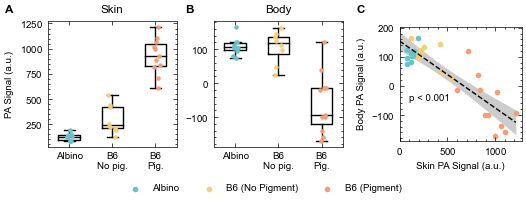

In [6]:
# Make the scatter plot
fig = plt.figure(figsize=(5.25, 5.24 / 3))
subfiga, subfigb = fig.subfigures(1, 2, width_ratios=[2, 1])
ax1, ax2 = subfiga.subplots(1, 2, sharex=True)
ax3 = subfigb.subplots()

df = pd.read_pickle("intermediate results/skin_core_data.pd")

single_wavelength_data = (
    df.explode(["Wavelength", "Rim Signal", "Core Signal"])
    .set_index("Wavelength")
    .loc[700.0]
)

single_wavelength_data["Rim Signal"] = single_wavelength_data["Rim Signal"].astype(
    np.float64
)
single_wavelength_data["Core Signal"] = single_wavelength_data["Core Signal"].astype(
    np.float64
)

single_wavelength_data["mp"] = (
    single_wavelength_data["Mouse Type"] + single_wavelength_data["pigmentation"]
)
single_wavelength_data["rs"] = single_wavelength_data["Rim Signal"]
single_wavelength_data["cs"] = single_wavelength_data["Core Signal"]

position = [1, 2, 3]

i = 0

# Make a data frame for stats:
df_stats = single_wavelength_data.copy()
df_stats["A"] = df_stats["Core Signal"]
df_stats["MP"] = df_stats["Mouse Type"] + df_stats["pigmentation"]
df_stats["M"] = df_stats["Mouse Type"]
df_stats["P"] = df_stats["pigmentation"]
df_stats["R"] = df_stats["Rim Signal"]

# Relate core signal to mouse type and pigmentation
formula = "A ~ C(M) + C(P)"
lm1 = smf.ols(formula, df_stats).fit()
# Relate rim signal to mouse type and pigmentation
formula = "R ~ C(M) + C(P)"
lm2 = smf.ols(formula, df_stats).fit()
# Relate core signal to rim signal
formula = "A ~ R"
lm3 = smf.ols(formula, df_stats).fit()


def tidy(d):
    for x in d.pvalues.keys():
        print(f"{x}: {d.pvalues[x]:.3f}")


print("Plot A")
tidy(lm2)
print("Plot B")
tidy(lm1)
print("Plot C")
tidy(lm3)


# Scatter plots
for (mouse, pig), t in single_wavelength_data.groupby(["Mouse Type", "pigmentation"]):
    label = mouse + (" " + pig if mouse == "B6" else "")
    label = label.replace("No", "(No Pigment)")
    label = label.replace("Yes", "(Pigment)")
    assert labels[i] == label
    t = t.sort_values("Rim Signal")
    core, rim = np.asarray(t["Core Signal"]), np.asarray(t["Rim Signal"])

    ax3.scatter(rim, core, color=Pastel_3.mpl_colors[i], label=label)

    ax1.boxplot(
        t["rs"],
        positions=[position[i]],
        widths=[0.5],
        bootstrap=1000,
        medianprops=dict(color="k"),
        showfliers=False,
    )

    positions = position[i] + (np.random.random(len(t["rs"])) - 0.5) * 0.2

    ax1.scatter(positions, t["rs"], color=Pastel_3.mpl_colors[i], zorder=1000, s=5)
    ax2.scatter(positions, t["cs"], color=Pastel_3.mpl_colors[i], zorder=1000, s=5)

    ax2.boxplot(
        t["cs"],
        positions=[position[i]],
        widths=[0.5],
        bootstrap=1000,
        medianprops=dict(color="k"),
        showfliers=False,
    )

    i += 1


xe = np.linspace(0, np.max(single_wavelength_data["Rim Signal"]))
res, prediction = linear_regression(
    np.asarray(single_wavelength_data["Rim Signal"]),
    np.asarray(single_wavelength_data["Core Signal"]),
    x_predict=xe,
)
p = prediction.pvalues[1]
p_label = f"p = {p:.3f}" if p > 0.001 else "p < 0.001"

ax3.annotate(p_label, (100, -50))

ax3.plot(xe, res.predicted_mean, c="k", linestyle="--")
ax3.fill_between(xe, *res.conf_int().T, color="k", alpha=0.2, zorder=-100, linewidth=0)

ax1.set_xticks([1, 2, 3], ["Albino", "B6\nNo pig.", "B6\nPig."])
# ax1.tick_params(axis='x', which='major', color=[0, 0, 0, 0])
ax1.set_ylabel("Body $\mathbf{sO_2^{MSOT}}$")
ax1.set_xlim([min(position) - 0.5, max(position) + 0.5])

ax2.set_xticks([1, 2, 3], ["Albino", "B6\nNo pig.", "B6\nPig."])
# ax1.tick_params(axis='x', which='major', color=[0, 0, 0, 0])
ax2.set_xlim([min(position) - 0.5, max(position) + 0.5])

ax1.set_ylabel("PA Signal (a.u.)")
ax1.set_title("Skin")
ax2.set_title("Body")

ax3.set_xlabel("Skin PA Signal (a.u.)")
ax3.set_ylabel("Body PA Signal (a.u.)")
ax3.set_xlim([0, None])

ax1.set_xticks([], [], minor=True)
ax2.set_xticks([], [], minor=True)

fig.legend(
    *ax3.get_legend_handles_labels(),
    frameon=False,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.0),
    ncol=3,
)

add_axis_label(ax1, "A")
add_axis_label(ax2, "B")
add_subfigure_label(subfigb, ax3, "C")

plt.savefig("../figures/mouse_quantification.png", dpi=300)
plt.savefig("../figures/mouse_quantification.pdf", dpi=300)
plt.show()

Intercept      3.155407e-22
C(M)[T.B6]     1.633805e-02
C(P)[T.Yes]    1.056166e-02
dtype: float64
Probability that B6 is greater than albino (without including pigmentation effect) p = 0.016
Probability that pigmentation leads to a raised sO2 p = 0.011
Fit for plot B
3.178451552439795e-08


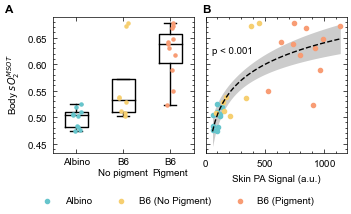

In [7]:
# Make the scatter plot
fig = plt.figure(figsize=(2 * 5.25 / 3, 5.25 / 3))

ax1, ax3 = fig.subplots(1, 2, sharey=True)

df = pd.read_pickle("intermediate results/skin_core_data.pd")

df["Labels"] = [("Hb", "HbO2")] * len(df)
df = df.reset_index()

single_wavelength_data = df.explode(
    ["Rim Unmixed", "Core Unmixed", "Labels"]
).set_index(["Labels", "index"])
so2 = single_wavelength_data.loc["HbO2", "Core Unmixed"] / (
    single_wavelength_data.loc["Hb", "Core Unmixed"]
    + single_wavelength_data.loc["HbO2", "Core Unmixed"]
)
df["core so2"] = so2.astype(np.float64)
so2 = single_wavelength_data.loc["HbO2", "Rim Unmixed"] / (
    single_wavelength_data.loc["Hb", "Rim Unmixed"]
    + single_wavelength_data.loc["HbO2", "Rim Unmixed"]
)
df["rim so2"] = so2.astype(np.float64)
df["Rim Signal"] = df["Rim Signal"].apply(np.median).astype(np.float64)
position = [1, 2, 3]

# Make a data frame for stats:
df_so2 = df.copy()
df_so2["A"] = df_so2["core so2"]
df_so2["MP"] = df_so2["Mouse Type"] + df_so2["pigmentation"]
df_so2["M"] = df_so2["Mouse Type"]
df_so2["P"] = df_so2["pigmentation"]
df_so2["R"] = df_so2["Rim Signal"]

formula = "A ~ C(M) + C(P)"
lm3 = smf.ols(formula, df_so2).fit()
print(lm3.pvalues)

i = 0

# Scatter plots
for (mouse, pig), t in df.groupby(["Mouse Type", "pigmentation"]):
    t = t[~(t["core so2"] < -0.5)]
    t = t[~(t["core so2"] > 2)]
    label = mouse + (" " + pig if mouse == "B6" else "")
    label = label.replace("No", "(No Pigment)")
    label = label.replace("Yes", "(Pigment)")
    assert labels[i] == label
    t = t.sort_values("Rim Signal")
    rim = np.asarray(t["Rim Signal"])
    so2 = np.asarray(t["core so2"])

    ax3.scatter(rim, so2, color=Pastel_3.mpl_colors[i], label=label)
    ax1.boxplot(
        t["core so2"],
        positions=[position[i]],
        widths=[0.5],
        bootstrap=1000,
        medianprops=dict(color="k"),
        showfliers=False,
    )

    positions = position[i] + (np.random.random(len(t["core so2"])) - 0.5) * 0.2
    ax1.scatter(
        positions, t["core so2"], color=Pastel_3.mpl_colors[i], zorder=1000, s=5
    )

    if i == 1:
        p = lm3.pvalues["C(M)[T.B6]"]
        text = f"p = {p:.3f}" if p > 0.001 else "p < 0.001"
        # ax1.annotate(text, (position[i], np.max(t["core so2"])), xytext=(0, -32), textcoords="offset points", ha="center")
        print(
            "Probability that B6 is greater than albino (without including pigmentation effect)",
            text,
        )
    elif i == 2:
        p = lm3.pvalues["C(P)[T.Yes]"]
        text = f"p = {p:.3f}" if p > 0.001 else "p < 0.001"
        # ax1.annotate(text, (position[i], np.max(t["core so2"])), xytext=(0, -32), textcoords="offset points", ha="center")
        print("Probability that pigmentation leads to a raised sO2", text)
    i += 1

x_p = np.linspace(0, 12)

df_so2 = df.copy()  # [df["Mouse Type"] == "B6"].copy()
# df_so2 = df_so2[~(df_so2["core so2"] < -0.5)]
# df_so2 = df_so2[~(df_so2["core so2"] > 2)]
df_so2["A"] = df_so2["core so2"]
df_so2["MP"] = df_so2["Mouse Type"] + df_so2["pigmentation"]
df_so2["M"] = df_so2["Mouse Type"]
df_so2["P"] = df_so2["pigmentation"]
df_so2["R"] = df_so2["Rim Signal"]

xe = np.linspace(np.min(df["Rim Signal"]), np.max(df["Rim Signal"]))

prediction = smf.ols("A ~ np.log(R)", df_so2).fit()
print("Fit for plot B")
res = prediction.get_prediction(sm.add_constant(pd.DataFrame({"R": xe})))
# res, prediction = linear_regression(np.asarray(df_so2["Rim Signal"]), np.asarray(df_so2["core so2"]), x_predict=xe)

p = prediction.pvalues[1]
print(p)
p_label = f"p = {p:.3f}" if p > 0.001 else "p < 0.001"
ax3.annotate(p_label, (50, 0.62))

ax3.plot(xe, res.predicted_mean, c="k", linestyle="--")
ax3.fill_between(xe, *res.conf_int().T, color="k", alpha=0.2, zorder=-100, linewidth=0)

ax1.set_xticks([1, 2, 3], ["Albino", "B6\nNo pigment", "B6\nPigment"])
# ax1.tick_params(axis='x', which='major', color=[0, 0, 0, 0])
ax1.set_ylabel(r"Body $sO_2^{MSOT}$")
ax1.set_xlim([min(position) - 0.5, max(position) + 0.5])

ax3.set_xlabel("Skin PA Signal (a.u.)")
ax3.set_xlim([0, None])
fig.legend(
    *ax3.get_legend_handles_labels(),
    frameon=False,
    loc="upper center",
    ncol=3,
    bbox_to_anchor=(0.5, 0),
)

add_axis_label(ax1, "A", manual_y=0.1)
add_axis_label(ax3, "B", manual_y=0.1)

ax1.set_xticks([], [], minor=True)

plt.savefig("../figures/mice_quantification_so2.png", dpi=300)
plt.savefig("../figures/mice_quantification_so2.pdf", dpi=300)
plt.show()

In [8]:
df_so2 = df.copy()
df_so2["A"] = df_so2["core so2"]
df_so2["MP"] = df_so2["Mouse Type"] + df_so2["pigmentation"]
df_so2["M"] = df_so2["Mouse Type"]
df_so2["P"] = df_so2["pigmentation"]
df_so2["R"] = df_so2["Rim Signal"]

formula = "A ~ M + R"
lm3 = smf.ols(formula, df_so2).fit(cov_type="HC3")
print(lm3.pvalues)

Intercept    0.000000
M[T.B6]      0.064744
R            0.000088
dtype: float64


In [9]:
df[["Mouse Type", "pigmentation", "Scan Name"]].groupby(
    ["Mouse Type", "pigmentation"]
).describe()

Scan Name         \
                            count unique   
Mouse Type pigmentation                    
Albino     No                  10     10   
B6         No                   8      8   
           Yes                 11     11   

                                                                      
                                                            top freq  
Mouse Type pigmentation                                               
Albino     No            20220711_EVB_1L1R_34249_KIDNEYS_SPLEEN    1  
B6         No              20221206_TRE_1R_44411_KIDNEYS_SPLEEN    1  
           Yes             20221219_TRE_NM_44410_KIDNEYS_SPLEEN    1

In [10]:
df_export = df_so2.copy()

df_export["Core Signal"] = df_export["Core Signal"].apply(lambda x: x[0])

export_columns = ["Mouse Type", "pigmentation", "Rim Signal", "core so2", "Core Signal"]

rename_columns = ["MouseType", "Pigmentation", "RimSignal", "CoreSO2", "CoreSignal"]

cols = dict(zip(export_columns, rename_columns))
df_export = df_export.rename(columns=cols)

df_export = df_export[rename_columns]

In [11]:
df_export.to_csv("mouse_data.csv")